Imports

In [22]:
import numpy as np
import random
import scipy.ndimage
from scipy.ndimage import generic_filter, convolve
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import rasterio
import warnings

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

Read and downcast data for efficiency

In [2]:
# Load the TIF files
dataset1 = rasterio.open('combined_urban_expansion_Beijing.tif')
dataset2 = rasterio.open('combined_urban_expansion_Athens.tif')

# Read and preprocess the data
data1 = dataset1.read().astype(np.int8)
data2 = dataset2.read().astype(np.int8)

Downample image data to make training viable (if memory constraints apply). Alternatively you could add some encoder-decoder layers.

In [3]:
z = 256
target_shape = (z, z)
# Resample data to 256x256
def resample_data(data, target_shape):
    zoom_factors = (1, target_shape[0] / data.shape[1], target_shape[1] / data.shape[2])
    return scipy.ndimage.zoom(data, zoom_factors, order=0)

resampled_data1 = resample_data(data1, target_shape)
resampled_data2 = resample_data(data2, target_shape)

Sanity check to confirm data is still binary

In [4]:
# Check if data is binary
assert np.all(np.logical_or(resampled_data1 == 0, resampled_data1 == 1))
assert np.all(np.logical_or(resampled_data2 == 0, resampled_data2 == 1))

Break up the images into sequences of 5 and the 6th following the sequence. Its ok to use shufle = True since the sequences is what is being passed.

In [5]:
seed = 8
def sequencer(data, dates, seq_length=5):
    X, y, X_dates, y_dates = [], [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
        X_dates.append(dates[i:i+seq_length])
        y_dates.append(dates[i+seq_length])
    X, y, X_dates, y_dates = np.array(X), np.array(y), np.array(X_dates), np.array(y_dates)
    return train_test_split(X, y, X_dates, y_dates, test_size=0.1, shuffle=True, random_state=seed)
dates1 = np.arange(1986, 2019)
dates2 = np.arange(1985, 2019)

X_train1, X_test1, y_train1, y_test1, X_train_dates1, X_test_dates1, y_train_dates1, y_test_dates1 = sequencer(resampled_data1, dates1)
X_train2, X_test2, y_train2, y_test2, X_train_dates2, X_test_dates2, y_train_dates2, y_test_dates2 = sequencer(resampled_data2, dates2)

Join the datasets of the two cities to prevent overfitting later.

In [6]:
X_train = np.concatenate((X_train1, X_train2), axis=0)
X_test = np.concatenate((X_test1, X_test2), axis=0)
y_train = np.concatenate((y_train1, y_train2), axis=0)
y_test = np.concatenate((y_test1, y_test2), axis=0)
X_test_dates = np.concatenate((X_test_dates1, X_test_dates2), axis=0)
y_test_dates = np.concatenate((y_test_dates1, y_test_dates2), axis=0)

Fix the dimentions by adding the missing channel dimention.

In [7]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

Augment the data by rotating the sequences of images by 90, 180 and 270 degrees. After all 60 images is a pretty small dataset to train a neural network

In [9]:
def rotate_sequences(X, y):
    X_rot90 = np.rot90(X, k=1, axes=(2, 3))
    X_rot180 = np.rot90(X, k=2, axes=(2, 3))
    X_rot270 = np.rot90(X, k=3, axes=(2, 3))
    
    y_rot90 = np.rot90(y, k=1, axes=(1, 2))
    y_rot180 = np.rot90(y, k=2, axes=(1, 2))
    y_rot270 = np.rot90(y, k=3, axes=(1, 2))
    
    X_augmented = np.concatenate((X, X_rot90, X_rot180, X_rot270), axis=0)
    y_augmented = np.concatenate((y, y_rot90, y_rot180, y_rot270), axis=0)
    
    return X_augmented, y_augmented

# Augment the training data
X_augmented, y_augmented = rotate_sequences(X_train, y_train)
X_augmented_train, X_augmented_validation, y_augmented_train, y_augmented_validation = train_test_split(
    X_augmented,
    y_augmented, 
    test_size=0.1, 
    shuffle=False, # Toggle to True for training, False to be able to access the original unrotated images
    random_state=seed)

Final sanity check before training

In [13]:
assert np.all(np.logical_or(X_augmented_train == 0, X_augmented_train == 1))
assert np.all(np.logical_or(y_augmented_train == 0, y_augmented_train == 1))
print(f"Original X_train shape: {X_train.shape}\n"
      f"Augmented X_train shape: {X_augmented_train.shape}\n"
      f"Original y_train shape: {y_train.shape}\n"
      f"Augmented y_train shape: {y_augmented_train.shape}\n"
      f"Validate X_test shape: {X_augmented_validation.shape}\n"
      f"Validate y_test shape: {y_augmented_validation.shape}")

Original X_train shape: (51, 5, 256, 256, 1)
Augmented X_train shape: (183, 5, 256, 256, 1)
Original y_train shape: (51, 256, 256, 1)
Augmented y_train shape: (183, 256, 256, 1)
Validate X_test shape: (21, 5, 256, 256, 1)
Validate y_test shape: (21, 256, 256, 1)


Example: The second image of the 11th sequence 

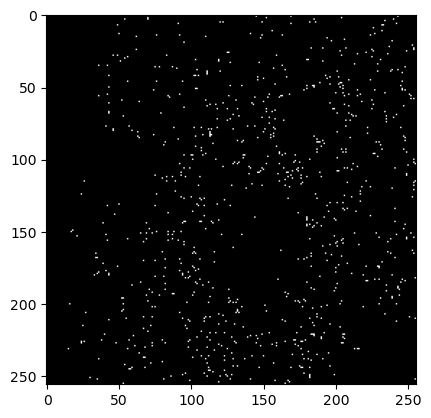

In [17]:
plt.imshow(X_augmented_train[11, 1, :, :, ], cmap='binary_r')

Define the custom loss function and the model.

In [18]:
# Define the weighted binary cross-entropy loss function
def weighted_binary_crossentropy(y_true, y_pred):
    y_true_float = K.cast(y_true, 'float32')
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    weights = (y_true_float * 2) + 1 # Example: Adjust weights as needed
    loss = -weights * y_true_float * K.log(y_pred) - (1 - y_true_float) * K.log(1 - y_pred)
    return K.mean(loss)

# Define the ConvLSTM model with dropout and batch normalization
def create_conv_lstm_model_with_l2(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', kernel_regularizer=l2(0.01)))
    return model

Initialise a model, add early stopping, checkpoints and learning rate reduction at plateus.

In [19]:
# Example usage
input_shape = (5, z, z, 1)  # Adjust according to your data
model = create_conv_lstm_model_with_l2(input_shape)



# Compile the model
model.compile(optimizer='adam',
              loss=weighted_binary_crossentropy,
              metrics=[tf.keras.metrics.AUC(name='auc')])

# Callbacks for early stopping, model checkpoint, and learning rate reduction
early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(filepath='Mixed_wbc_auc_{epoch:02d}_{val_loss:.2f}.h5', save_best_only=True, monitor='val_auc', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=5, min_lr=1e-5, mode='max')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 5, 256, 256, 32)   38144     
                                                                 
 batch_normalization (BatchN  (None, 5, 256, 256, 32)  128       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 5, 256, 256, 16)   27712     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 256, 256, 16)  64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 256, 256, 16)      18496     
                                                                 
 batch_normalization_2 (Batc  (None, 256, 256, 16)     6

Train the model.

In [ ]:
history = model.fit(X_augmented_train, y_augmented_train,
                    epochs=100,
                    validation_data=(X_augmented_validation, y_augmented_validation),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    batch_size=10)

Load it.

In [20]:
finished = tf.keras.models.load_model(
    'Mixed_wbc_auc_60_0.16.h5',
    custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy})

Ecaluate it.

In [21]:
finished.metrics
loss, auc = finished.evaluate(X_test, y_test)

1/1 [==============================] - 9s 9s/step - loss: 0.1414 - auc: 0.8252


Make Predicitons on the tets set

In [26]:
predictions = finished.predict(X_test)

1/1 [==============================] - 9s 9s/step


Make function to statistically threshhold pixel values using a nearest neighbour approach to "sharpen" predictions

In [27]:
def threshold_prediction_2d(prediction, threshold, kernel_size):
    # Define a function to compute the standard deviation
    def std_dev(neighbors):
        return np.std(neighbors)

    # Compute the standard deviation of the 8 nearest neighbors for each pixel
    neighbor_std = generic_filter(prediction, std_dev, size=(kernel_size, kernel_size))

    # Define the kernel that will be used to compute the average of the 8 nearest neighbors
    x, y = np.mgrid[-kernel_size//2 + 1:kernel_size//2 + 1, -kernel_size//2 + 1:kernel_size//2 + 1]
    pos = np.dstack((x, y))
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    kernel = rv.pdf(pos)

    # Compute the average of the 8 nearest neighbors for each pixel
    neighbor_avg = convolve(prediction, kernel, mode='constant', cval=0.0)

    # Apply the threshold
    return np.where(neighbor_avg > np.median(prediction) + threshold * neighbor_std,neighbor_avg, 0)

In [28]:
threshold_predictions = []
for i in range(len(predictions)):
    threshold_predictions.append(threshold_prediction_2d(predictions[i].squeeze(),kernel_size=3, threshold=2))

Plot the test set along with the ground truth , initial prediction and "thresholded" prediction

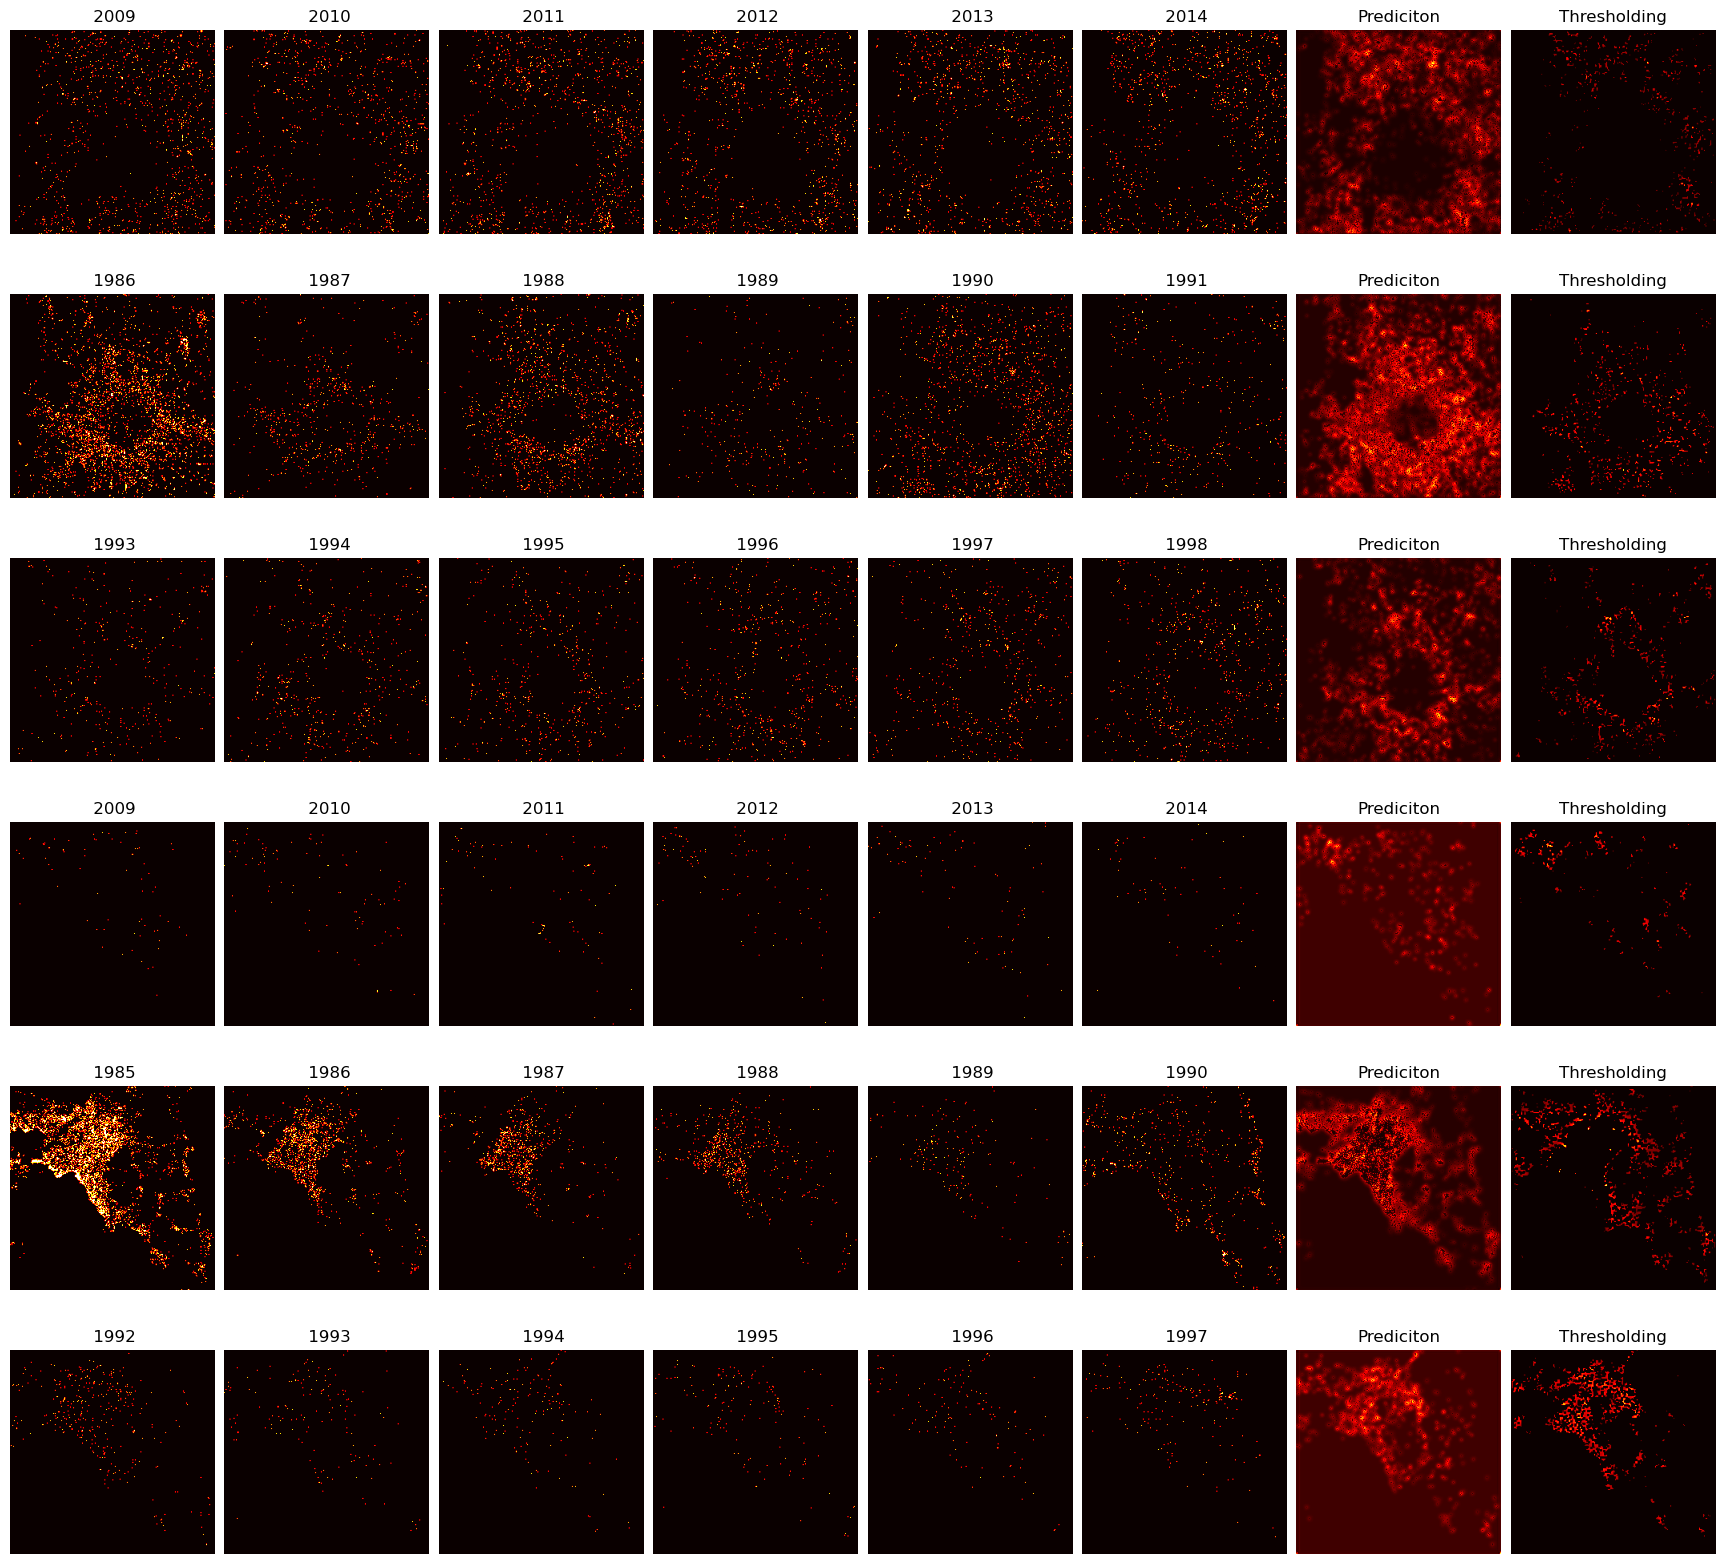

In [29]:
fig, axes = plt.subplots(nrows=len(X_test), ncols=8, figsize=(22, 20))
plt.subplots_adjust(wspace=0.05)
cmap1 = colors.LinearSegmentedColormap.from_list("", ["black","lime"])
for i in range(len(X_test)):
    for j in range(5):
        axes[i, j].imshow(X_test[i, j].squeeze(), cmap='hot')
        axes[i, j].axis('off')
        axes[i, j].set_title(f' {X_test_dates[i,j]}')
    axes[i, 5].imshow(y_test[i].squeeze(),cmap='hot' )
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f' {y_test_dates[i]}')
    
    axes[i, 6].imshow(predictions[i],cmap='hot')
    axes[i, 6].axis('off')
    axes[i, 6].set_title(f'Prediciton')

    axes[i, 7].imshow(threshold_predictions[i],cmap='hot')
    axes[i, 7].axis('off')
    axes[i, 7].set_title(f'Thresholding')